In [1]:
# # Install required packages (NB: they may already be installed on your machine)
# install.packages("tidyverse")
# install.packages("infer")
# install.packages("janitor")
# install.packages("repr")
# install.packages("stringr")
# install.packages("waffle", repos = "https://cinc.rud.is")
# install.packages("plyr")
# install.packages("ggthemes")

# # Waffle is sometimes finicky, so you might also need this to run this notebook locally
# remotes::install_github("hrbrmstr/waffle")

In [2]:
# Load required packages
library(plyr)
library(tidyverse)
library(infer)
library(janitor)
library(repr)
library(stringr)
library(waffle)
library(ggthemes)

-- Attaching packages ------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::arrange()   masks plyr::arrange()
x purrr::compact()   masks plyr::compact()
x dplyr::count()     masks plyr::count()
x dplyr::failwith()  masks plyr::failwith()
x dplyr::filter()    masks stats::filter()
x dplyr::id()        masks plyr::id()
x dplyr::lag()       masks stats::lag()
x dplyr::mutate()    masks plyr::mutate()
x dplyr::rename()    masks plyr::rename()
x dplyr::summarise() masks plyr::summarise()
x dplyr::summarize() masks plyr::summarize()


Attaching package: 'janitor'


The following objects are masked from 'package:stats':

    chisq.test, fisher.test




In [3]:
# Custom ggplot theme for use throughout the analysis
# Idea from [Joey Stanley](https://joeystanley.com/blog/custom-themes-in-ggplot2)
theme_stat201 <- function (width = 12, height = 5) { 
    options(repr.plot.width = width, repr.plot.height = height)
    theme_bw(base_size = 14) %+replace% 
        theme(
            plot.title = element_text(hjust = 0.5) 
        )
}

In [4]:
# A helper function to generate figure numbers
# TODO: figure out how to make figure_number increment correctly
create_caption <- function (figure_number, title) {
    print(paste(sprintf("Figure #%d:", figure_number), title))
}
create_caption(0, "Hello, world!")

[1] "Figure #0: Hello, world!"


In [5]:
# The seed used for the entirety of our analysis
SEED <- 12345

# Examining the Impact of COVID-19 on the Proportion of Theft-Related Crimes in Vancouver

**Authors** Group 4, Project Proposal (Acky Xu, Adam Mitha, Icy Xu, Michael DeMarco)

**Abstract** This project looks at the impact of the COVID-19 pandemic on theft-related crime in select Vancouver neighborhoods. Inferential techniques are applied to estimate the difference in the proportion of theft crime relative to all crime between 2020 and the mean proportion of the three previous years (2017 to 2019); we test to see if there has been a statistically significant change in the proportion of theft related crime on the whole across Vancouver. Our findings are still to be determined, and will be included in the final report. We anticipated we would find a significant in theft related crime overall due to, presumably, the economic hardship induced by the COVID-19 pandemic in 2020; in the end, we instead found that only roughly half of all examined neighborhoods saw no significant change in theft related crime.

<p style="display: block; text-align: center;">
    <img style="display: block; margin: 0 auto;" src="./vpd.jpg" alt="A VPD car" width="50%" />
</p>

<p style="text-align: center;"><i>A Vancouver Police Department (VPD) car.</i></p>

## Introduction

### Background 

Since the beginning of the COVID-19 pandemic in March of 2020, many have discussed the issue of alleged increasing crime rates both globally and within Metro Vancouver. Indeed, an unprecedented economic contraction [[Statistics Canada, 1]](https://www150.statcan.gc.ca/n1/pub/11-631-x/2020004/conclusions-eng.htm) coupled with fewer resources, such as shelters or food banks, has driven an increase in many types of crime, including in fraud and counterfeiting crime [[Interpol, 2]](https://www.interpol.int/en/News-and-Events/News/2019/Operation-Pangea-shining-a-light-on-pharmaceutical-crime), hate crimes [[ABC News, 3]](https://abcnews.go.com/US/fbi-warns-potential-surge-hate-crimes-asian-americans/story?id=69831920)—with those of East Asian descent being impacted most significantly—and domestic violence [[UN News, 4]](https://news.un.org/en/story/2020/04/1061052).

These spikes have led to tension between municipal governments and police departments with respect to budgeting in the wake of the economic depravity of the COVID-19 era. The City of Vancouver, specifically, enacted a freeze on the police budget in 2021 [[CBC, 5]](https://www.cbc.ca/news/canada/british-columbia/city-of-vancouver-freezes-police-department-funding-as-part-of-2021-budget-1.5833731). However, there is little publicly available Vancouver-focused analysis on theft-related crime specifically, and trends in crime generally, in the years leading up to that decision.

Existing literature relating to crime and the COVID-19 pandemic has primarily focused on many types of "global" crime (e.g., organized crime, terrorist attacks), and has largely concluded that on the whole, these types of crimes are increasing through the pandemic year; in our analysis, we'll look closely at "petty" crimes, specifically theft, and see how, if at all, the rate of theft crime has changed amidst the pandemic. We choose three neighborhoods—Strathcona, Marpole, and Shaughnessy—for our analysis. Per the City of Vancouver's 2016 local area profiles, these are the "average total incomes among residents"  in those three neighborhoods [[City of Vancouver, 9]](https://opendata.vancouver.ca/explore/dataset/census-local-area-profiles-2016/information/):

- [ ] Fix neighborhoods

* Shaughnessy, \$118,668
* Marpole, \$39,020
* Strathcona, \$31,534

(While the VPD has no direct data for neighborhood wealth, we can use the City of Vancouver's local profiles as they match the VPD's neighborhood classifications. Other studies of mean incomes among residents in Vancouver neighborhoods aren't guaranteed to share the same neighborhood boundaries as the City of Vancouver and VPD data sets.) Thus, we have the "upper class," "middle class," and "lower class" represented by each neighborhood respectively.

### Question

We are interested in exploring how much, if at all, the proportion of petty crime rates have changed in Metro Vancouver over the last year. We will compare crime rates from 2017 to 2020 in neighborhoods characteristic of the full economic spectrum. Our analysis is narrowed to focusing on specifically theft, so we can best understand the intertwined relationships between the economic hardships brought forward over this last year, and trends in crime that would seemingly be induced by someone incurring job loss, for example.

- [ ] Fix neighborhoods

Therefore, our research question is as follows: _"How has the proportion of theft-related crime changed, if at all, in Vancouver during 2020, the year of the COVID-19 pandemic, when compared to the average of the previous three years (2017 to 2019) across the various strata of Vancouver's economic spectrum, studied via three neighborhoods: Strathcona, Marpole, and Shaughnessy?"_

### Data set

We're considering our sample to be what is available in the Vancouver Police Department's database. Within the data set description, the VPD mention "[t]he information provided [...] does not reflect the total number of calls or complaints made to the VPD" and "the crime classification [...] may change at any time based on the dynamic nature of police investigations." Additionally, we have to consider that many crimes go unreported for various reasons, such as for a fear of not being believed, insecurity, and a fear of getting into trouble; therefore, we cannot presume it is completely representative of both all crimes and all thefts within Vancouver. There is no specific study for unreported crimes statistics in Vancouver, but Statistic's Canada's "Police-reported crime statistics in Canada, 2019" survey indicated that just "one-third (31\%) of crimes are reported to police." [[link](https://www150.statcan.gc.ca/n1/pub/85-002-x/2020001/article/00010-eng.htm)]
 
Our population is _all_ actual crime that occurred in Vancouver, not just reported crime. Of course it is impossible to know how much crime actually occurred, but through our data set sample we'll be able to produce an estimate. Unfortunately, as we are working with the proportion of theft-related crime to _overall_ crime, attitudes towards policing over time becomes a rather significant confounding variable, as that could dramatically impact an individual's willingness to report a crime. There is significant cause to consider this confounding as well, as 2020 saw both the killing of George Floyd by a Minneapolis police officer and a little action done for the missing and murdered Indigenous women (MMIW) crisis here in Canada; this among other limitations will be discussed further in our analysis section. 

We will be using the Vancouver Police Department's Open Crime Data [[VPD, 6]](https://geodash.vpd.ca/opendata/) to answer our research question. In particular, we'll need three columns from the data set:

| Column | Description | Notes |
|-|-|-|
| Year | "A four-digit field that indicates the year when the reported crime activity" | We'll use data, specifically, from January 1st, 2017 to December 31st, 2020. |
| Type | "The type of crime activities" | We're considering theft crime to be all crime types with "theft" explicitly in the name. |
| Neighborhood | "Neighborhoods within the City of Vancouver are based on the census tract (CT) concept within census metropolitan area (CMA)." | We'll take three neighborhoods, representing the full economic spectrum. |

Our random variable of interest is the difference in the proportion of theft-related crime with respect to all crime between the mean of 2017 to 2019 and 2020 (i.e., before and during the COVID-19 pandemic). Given our population is all Vancouver crime, our parameter of interest is the difference in the proportion of theft related crime from the last three years 2017 to 2019 to 2020.

- [ ] Fix neighborhoods 

We will be estimating trends in all, "realized" crime in Vancouver by making estimates with our data set of reported crime across three different Vancouver neighborhoods, each characteristic of a different level of wealth. Thus, our location parameter is a proportion with an error reported by its standard error, which can be computed via bootstrapping, asymptotics, or mathematically, with the formula:

$$ {SE}_{\hat{p}_1 - \hat{p}_2} = \sqrt(\frac{\hat{p}_1\hat{q}_1}{n_1} + \frac{\hat{p}_2\hat{q}_2}{n_2}) $$

where

$$ p_i = 1 - q_i $$

- [ ] define variables 

We will also look at creating a confidence interval for the standard deviation of our proportion estimate as well, but this won't be the focus of our analysis [[Piazza, 7]](https://piazza.com/class/kjqe81ynudx2rm?cid=169). 

- [ ] todo: get rid of this

## Preliminary Results

We'll start by importing the dataset from it's original source [[VPD, 6]](https://geodash.vpd.ca/opendata), loading it into a dataframe and inspecting the results.

In [6]:
# Download the file to wherever your Jupyter notebook is located
url <- "https://geodash.vpd.ca/opendata/crimedata_download/crimedata_csv_all_years.zip"
filename <- "crime_data.zip"
download.file(url, destfile = filename)

# Data comes in as a zip, so we'll need to extract it
unzip("crime_data.zip")

# Read in the desired file
crime_data <- read_csv("crimedata_csv_all_years.csv")


-- Column specification ------------------------------------------------------------------------------------------------------
cols(
  TYPE = col_character(),
  YEAR = col_double(),
  MONTH = col_double(),
  DAY = col_double(),
  HOUR = col_double(),
  MINUTE = col_double(),
  HUNDRED_BLOCK = col_character(),
  NEIGHBOURHOOD = col_character(),
  X = col_double(),
  Y = col_double()
)




In [7]:
# Inspect the first and last three rows of the data frame
head(crime_data, n = 3)
tail(crime_data, n = 3)

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2012,12,14,8,52,NA,Oakridge,491285.0,5453433
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Vehicle Collision or Pedestrian Struck (with Injury),2016,6,20,18,11,YUKON ST / W KING EDWARD AVE,Riley Park,491786,5455143
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,3,9,49,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,27,14,40,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126


Our data largely comes in a "tidy" format already. By tidy, we're verifying (from the DSCI 100 course textbook [[Data Science: A First Introduction, 12]](https://ubc-dsci.github.io/introduction-to-datascience/), verbatim, which in turn is from Wickham and others [[R for Data Science, 11]](https://r4ds.had.co.nz/)): 
> * each row is a single observation,
> * each column is a single variable, and
> * each value is a single cell

However, there are four steps we could take to improve the data set for our use: 
1. clean up the column names,
2. remove N/As,
3. select only data relevant to our analysis, and
4. convert crime types and neighborhoods to a factor, since we're working with proportions (i.e., categorical data).

We're primarily interested in the year, type and neighborhood of crimes, so we'll extract those columns and discard the rest. In addition, we would like to focus on the years 2017 to 2020.

In [8]:
# 1. Generally, in R, you don't see ALL CAPS column names,
# so we can modify the column names manually (with the help)
# of the janitor library
crime_data <- crime_data %>% clean_names()
head(crime_data)

Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00C4>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00D6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00DC>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00E4>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00F6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00FC>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00DF>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00C6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00E6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00D8>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00F8>' to native encoding"
Warning message in FU

type,year,month,day,hour,minute,hundred_block,neighbourhood,x,y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2012,12,14,8,52,NA,Oakridge,491285.0,5453433
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2005,11,14,3,9,10XX ALBERNI ST,West End,491021.4,5459161


In [9]:
# 2. Remove all NAs (Note: na.omit(...) applies to the entire data frame, 
# but neighbourhood is used as an example)

total_rows <- crime_data %>% nrow()
print(sprintf("There are %d rows in the data frame", total_rows))

na_neighbourhoods <- sum(is.na(crime_data$neighbourhood))
print(sprintf("Originally, there were %d NA values in the neighbourhood column", na_neighbourhoods))

crime_data <- na.omit(crime_data)

na_neighbourhoods <- sum(is.na(crime_data$neighbourhood))
print(sprintf("Now, there are %d NA values in the neighbourhood column", na_neighbourhoods))

[1] "There are 668167 rows in the data frame"
[1] "Originally, there were 70135 NA values in the neighbourhood column"
[1] "Now, there are 0 NA values in the neighbourhood column"


In [10]:
# 3. Select only type, year, neighbourhood
# Filter to the date range of 2017-2020
crime_data <- crime_data %>% 
    select(type, year, neighbourhood) %>%
    filter(2017 <= year & year <= 2020)
head(crime_data)

type,year,neighbourhood
<chr>,<dbl>,<chr>
Break and Enter Commercial,2019,Fairview
Break and Enter Commercial,2019,West End
Break and Enter Commercial,2020,West End
Break and Enter Commercial,2017,West End
Break and Enter Commercial,2018,West End
Break and Enter Commercial,2020,West End


In [11]:
# 4. Now, we'll convert `neighbourhood` and `type` to a factor, 
# since we're considering it categorical data
crime_data <- crime_data %>%
    mutate(type = as_factor(type)) %>%
    mutate(neighbourhood = as_factor(neighbourhood))
head(crime_data)

type,year,neighbourhood
<fct>,<dbl>,<fct>
Break and Enter Commercial,2019,Fairview
Break and Enter Commercial,2019,West End
Break and Enter Commercial,2020,West End
Break and Enter Commercial,2017,West End
Break and Enter Commercial,2018,West End
Break and Enter Commercial,2020,West End


Next, let's see how many different types of crimes there are present in our data set.

In [12]:
# Grab all unique crime types, and print them in a pretty way
crime_types <- unique(crime_data$type)
print(crime_types)

[1] Break and Enter Commercial                            
[2] Break and Enter Residential/Other                     
[3] Mischief                                              
[4] Other Theft                                           
[5] Theft from Vehicle                                    
[6] Theft of Bicycle                                      
[7] Theft of Vehicle                                      
[8] Vehicle Collision or Pedestrian Struck (with Fatality)
[9] Vehicle Collision or Pedestrian Struck (with Injury)  
9 Levels: Break and Enter Commercial ... Vehicle Collision or Pedestrian Struck (with Injury)


As was mentioned in the introduction, we're interested in theft related crime. Let's create a list of all theft related crime we see in this data set.

In [13]:
theft_crimes <- c("Other Theft", "Theft from Vehicle", 
                  "Theft of Bicycle", "Theft of Vehicle")

We can also check the neighborhoods present in this data set.

- [ ] TODO: fix neighborhoods

In [14]:
# Grab all unique crime types, and print them in a pretty way
neighbourhoods <- unique(crime_data$neighbourhood)
print(neighbourhoods)

 [1] Fairview                  West End                 
 [3] Central Business District Hastings-Sunrise         
 [5] Strathcona                Grandview-Woodland       
 [7] Mount Pleasant            Sunset                   
 [9] Kensington-Cedar Cottage  Stanley Park             
[11] Shaughnessy               Marpole                  
[13] Oakridge                  Kitsilano                
[15] Victoria-Fraserview       Kerrisdale               
[17] West Point Grey           Riley Park               
[19] Arbutus Ridge             Renfrew-Collingwood      
[21] Killarney                 South Cambie             
[23] Dunbar-Southlands         Musqueam                 
24 Levels: Fairview West End Central Business District ... Musqueam


We chose three neighborhoods that we believe are representative of different economic classes present in Vancouver, in terms of mean wealth: Shaughnessy, Strathcona, and Marpole. Let's save those as well.

In [15]:
chosen_neighbourhoods <- c("Shaughnessy", "Strathcona", "Marpole")

We're hoping to compare crime rates across years in neighborhoods that represent a reasonable distribution of incomes. For our proposal, we're going to be using the Shaughnessy, Strathcona, and Marpole neighborhoods. More on why these neighborhoods were chosen in particular is discussed in the "Methods" section.

In [16]:
# Filter down by the 3 neighbourhoods above
crime_data <- crime_data %>%
    filter(neighbourhood %in% chosen_neighbourhoods)

head(crime_data, n = 3)
tail(crime_data, n = 3)

type,year,neighbourhood
<fct>,<dbl>,<fct>
Break and Enter Commercial,2017,Strathcona
Break and Enter Commercial,2020,Strathcona
Break and Enter Commercial,2020,Strathcona


type,year,neighbourhood
<fct>,<dbl>,<fct>
Vehicle Collision or Pedestrian Struck (with Injury),2018,Strathcona
Vehicle Collision or Pedestrian Struck (with Injury),2018,Marpole
Vehicle Collision or Pedestrian Struck (with Injury),2018,Marpole


Now, to get a better sense of our data set, we'll produce three plots to explore, at a high level, what crime looks like in Vancouver both over time and by neighborhood. Our three plots will be:

1. A line plot of total police-reported crime over time, grouped by neighborhood; this will demonstrate the change in total crime over time
2. A stacked bar chart showing a breakdown of crime type, grouped by neighborhood; this will demonstrate the relative frequencies of each crime type, by neighborhood
3. A waffle plot to show to crime types proportions, grouped by year; this will demonstrate the relative frequencies of each crime type, by year

Let's begin with the line plot.

In [17]:
# To produce our line plot, first, we'll need to compute the total amount of crime
# by neighborhood and year
neighbourhood_year_counts <- crime_data %>%
    group_by(neighbourhood, year) %>% 
    summarise(n = n())
head(neighbourhood_year_counts)

`summarise()` has grouped output by 'neighbourhood'. You can override using the `.groups` argument.



neighbourhood,year,n
<fct>,<dbl>,<int>
Strathcona,2017,1772
Strathcona,2018,1986
Strathcona,2019,2168
Strathcona,2020,1708
Shaughnessy,2017,444
Shaughnessy,2018,414


[1] "Figure #1: A line plot depicting the number of total police-reported crimes over time by neighbourhood."


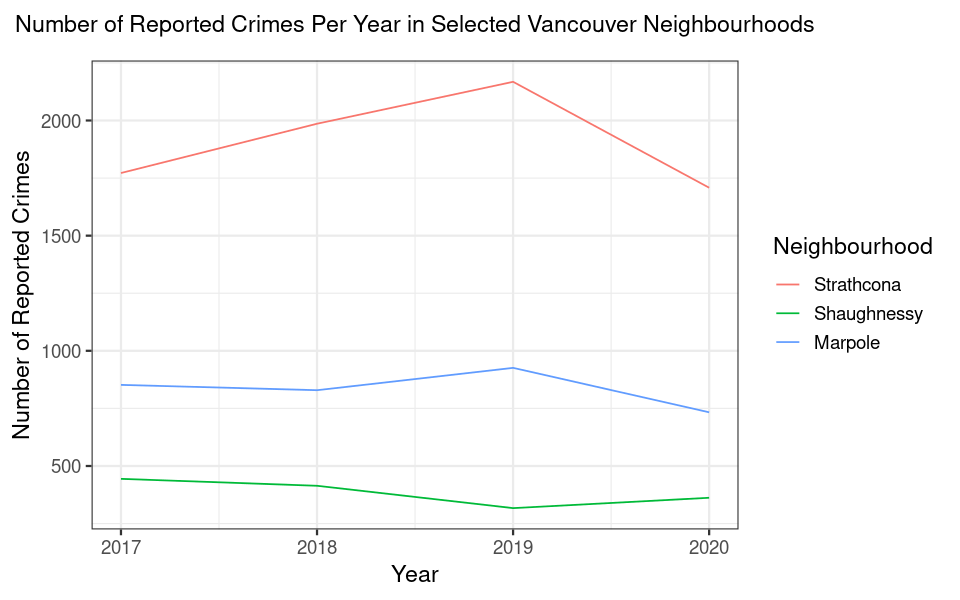

In [18]:
# 1. Finally, let's plot our data
crime_data_plot <- neighbourhood_year_counts %>%
    ggplot() +
    geom_line(aes(x = year, y = n, color = neighbourhood)) +
    scale_x_continuous(limits = c(2017, 2020)) +
    labs(x = "Year", y = "Number of Reported Crimes", color = "Neighbourhood") +
    ggtitle("Number of Reported Crimes Per Year in Selected Vancouver Neighbourhoods\n") +
    theme_stat201(8, 5)
crime_data_plot
create_caption(1, "A line plot depicting the number of total police-reported crimes over time by neighbourhood.")

It's clear that the crime is highest in Strathcona, followed by Marpole, and then Shaughnessy. Crime has also generally decreased in 2020, especially in Strathcona. 

Alongside checking the number of crimes total in each neighborhood, it's also worth looking at how much of each type of crime is represented in our data set. Let's now look at the stacked bar chart.

[1] "Figure #2: A stacked bar chart depicting the total number of crimes by type and neighbourhood."


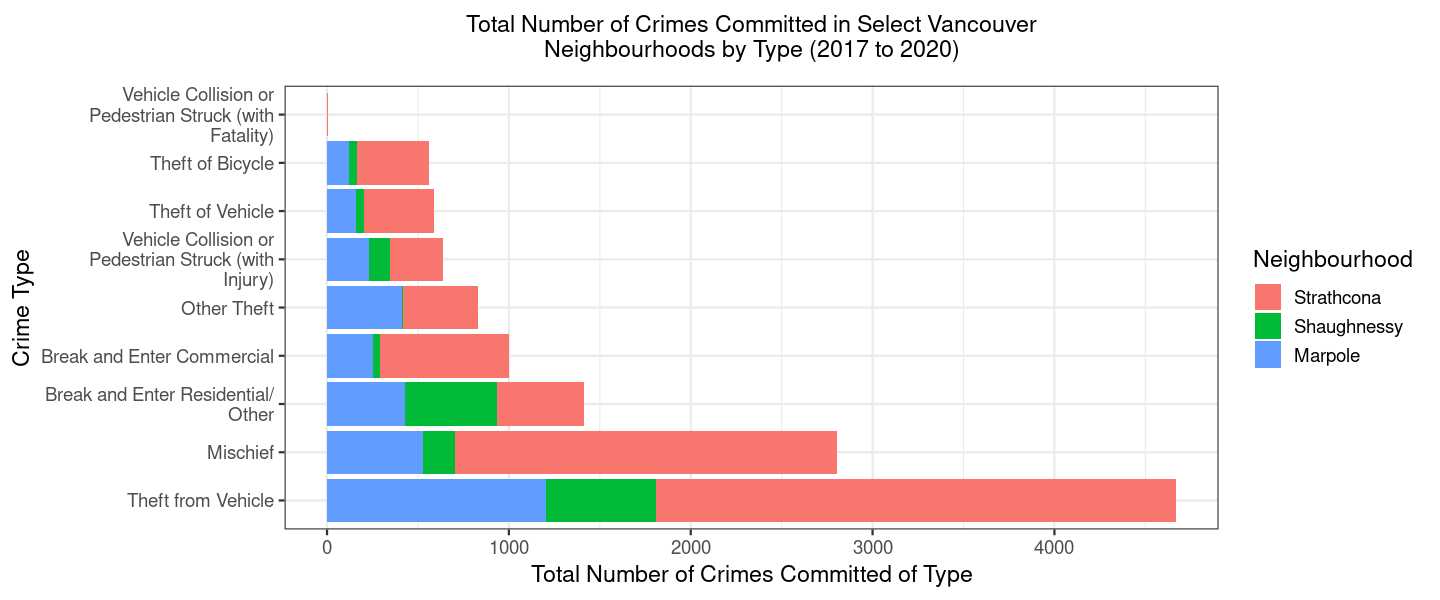

In [19]:
# 2. Note that the stringr::str_wrap call wraps the long label names for crime types, and
# reorder places the largest crime count on the bottom
crime_type_bar_plot <- crime_data %>%
    ggplot(aes(x = reorder(str_wrap(type, 30), type, function(x) - length(x)), fill = neighbourhood)) +
    geom_bar(position = "stack") +
    labs(x = "Crime Type", y = "Total Number of Crimes Committed of Type", fill = "Neighbourhood") +
    ggtitle("Total Number of Crimes Committed in Select Vancouver\nNeighbourhoods by Type (2017 to 2020)\n") +
    coord_flip() +
    theme_stat201()

# Vehicle collisions that result in fatality are (thankfully) very low,
# and almost distinguishable on the plot below                           
crime_type_bar_plot
create_caption(2, "A stacked bar chart depicting the total number of crimes by type and neighbourhood.")

This plot shows that theft from vehicle, in the Strathcona region, makes up a large proportion of all crimes committed. We can also see, thankfully, that vehicle collisions resulting in fatality make up such a small fraction of our data they're hard to distinguish.

Finally, we can look at a visualization of the relative frequencies of crime over the years through a waffle chart. N.B: Each individual square represents 30 police-reported crimes.

In [20]:
# Let's produce a count of the crime by year and type
crime_waffle <- crime_data %>%
    count(year, type) %>%
    mutate(n = n / 30)
head(crime_waffle)
# The geom_waffle() function will do some magic for us in terms of rounding

year,type,n
<dbl>,<fct>,<dbl>
2017,Break and Enter Commercial,7.233333
2017,Break and Enter Residential/Other,11.500000
2017,Mischief,21.500000
2017,Other Theft,7.433333
2017,Theft from Vehicle,37.700000
2017,Theft of Bicycle,4.466667


[1] "Figure #3: A waffle plot depicting the proportion of each crime time by year."


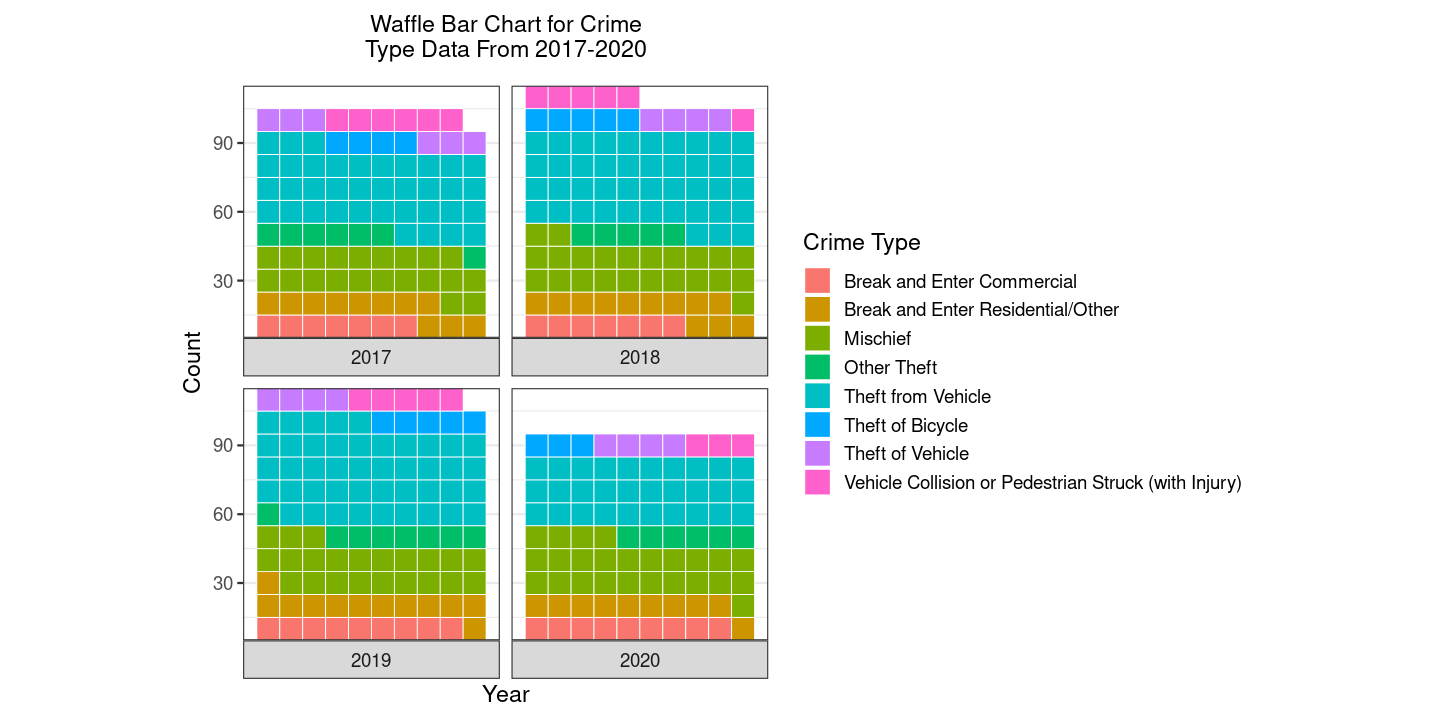

In [21]:
# 3. Let's look at the proportion of each crime committed over the years
waffle_plot <- crime_waffle %>%
    ggplot(aes(values = n, fill = type)) +
    geom_waffle(n_rows = 10, flip = TRUE, color = "white", size = 0.25) +
    facet_wrap(~year, nrow = 2, strip.position = "bottom") +
    scale_x_discrete() + 
    scale_y_continuous(labels = function(x) x * 10, # make this multiplier the same as n_rows
                       expand = c(0,0)) +
    labs(
        title = "Waffle Bar Chart for Crime\nType Data From 2017-2020\n",
        # subtitle = "A single square represents 30 crimes",
        x = "Year",
        y = "Count",
        fill = "Crime Type"
    ) +
    coord_equal() +
    theme_enhance_waffle() +
    theme(legend.position = "bottom") +
    theme_stat201(12, 6)
waffle_plot
create_caption(3, "A waffle plot depicting the proportion of each crime time by year.")

No trends are particularly obvious from the waffle plot, though we can see a clear reduction in crime overall in 2020, and it seems as though it is in large part due to a steep decline in "theft from vehicle" crimes.

Now, we can compute estimates of our parameter of interest across each of our different groups. In our case, this means computing the difference between the mean of the proportion of theft crimes committed across 2017 to 2019 and the proportion of theft crimes committed in 2020. Note the proportions are computed as the the total number of theft related crimes within a given neighborhood relative to the total of crimes that occurred within that neighborhood; hence the `group_by(...)` ahead of the computation of the proportion in the following code cell.

In [22]:
# Let's first compute the pre-COVID mean in each neighbourhood (merging 2017 to 2019)
before_pandemic_df_by_year <- crime_data %>%
    mutate(is_theft = as.numeric(type %in% theft_crimes)) %>%
    filter(year >= 2017 & year <= 2019) %>%
    group_by(neighbourhood, year) %>% # group by neighbourhood and year first!
    summarize(prop_theft = sum(is_theft) / n()) # compute theft crimes in neighbourhood / crimes in neighborhood
# View prop_theft by year (2017, 2018, 2019) and neighbourhood
# head(p_hat_pre_covid_by_year)

before_pandemic_df <- before_pandemic_df_by_year %>%
    group_by(neighbourhood) %>%
    summarize(prop_theft = mean(prop_theft)) %>%
    mutate(time = "Before pandemic") %>%
    mutate(time = as_factor(time))
head(before_pandemic_df)

`summarise()` has grouped output by 'neighbourhood'. You can override using the `.groups` argument.



neighbourhood,prop_theft,time
<fct>,<dbl>,<fct>
Strathcona,0.5578307,Before pandemic
Shaughnessy,0.4624363,Before pandemic
Marpole,0.5675852,Before pandemic


In [23]:
# Now let's get an estimate for the COVID mean by neighbourhood
during_pandemic_df <- crime_data %>%
    mutate(is_theft = as.numeric(type %in% theft_crimes)) %>%
    filter(year == 2020) %>%
    group_by(neighbourhood) %>%
    summarize(prop_theft = sum(is_theft) / n()) %>%
    mutate(time = "During pandemic") %>%
    mutate(time = as_factor(time))
head(during_pandemic_df)

neighbourhood,prop_theft,time
<fct>,<dbl>,<fct>
Strathcona,0.4385246,During pandemic
Shaughnessy,0.4364641,During pandemic
Marpole,0.5661664,During pandemic


In [24]:
# Summarize in table
prof_diff_df <- during_pandemic_df %>%
    rename(during_prop_theft = prop_theft) %>%
    select(during_prop_theft) %>%
    cbind(before_pandemic_df) %>%
    mutate(prop_diff = during_prop_theft - prop_theft) %>%
    select(neighbourhood, prop_diff)
head(prof_diff_df)

,neighbourhood,prop_diff
,<fct>,<dbl>
1,Strathcona,-0.11930610
2,Shaughnessy,-0.02597225
3,Marpole,-0.00141876


Note that a negative value indicates a _decrease_ in crime during 2020. Our initial data suggests that the proportion of theft-related crime has actually _decreased_ since the pandemic began. While this is a good estimate for us to begin our analysis with, it's by no means sufficient to conclude upon; more as to why that is the case is discussed below.

## Methods

### Strengths

Our report uses data from the Vancouver Police Department to study trends in crime across select Vancouver neighborhoods. It is "trustworthy" in the sense that we will look to be careful at providing _ranges_ of our final answer, rather than solely point estimates. However, that alone isn't enough to guarantee an effective analysis. 

We're also using kind-of blocking in our analysis. Crime has been linked to wealth (and more specifically, socioeconomic status, or SES) [[World Bank, 8]](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1745-9125.1999.tb00483.x), so we'll treat it as a blocking variable, and group our data by three neighborhoods that represent different levels of wealth; however, we do not ever randomly sample within those groups, as we're considering our data to already be a sample, so it's not exactly what "blocking" truly is. Regardless, this "grouping" step will help us draw meaningful conclusions within our analysis. 

Finally, we're being careful to not simply compare the trend of crime between 2019 and 2020. Since our focus is COVID-19, we're not especially interested in the 1-year trend, but rather, how 2020 has deviated from the "norm." It is plausible that 2019 was an outlier, so "merging" the 3-year span of 2017 to 2019 should provide us a better sense of the general, recent crime levels in Vancouver.

### Limitations

Some could argue that many of the "petty" crimes we're interested in, like theft, largely go unreported. And while our analysis does indeed aim to provide an estimate from this sample of strictly reported crimes, arguing what makes a "fair" range is a hard question to answer. Countless factors affect whether or not a crime gets reported, and trust in police generally was found to be at a "record low" in August of 2020 [[New York Times, 10]](https://www.nytimes.com/2020/08/12/us/gallup-poll-police.html). Accounting for this variability, statistically, is arduous.

Furthermore, while our neighborhood selections do represent a fair amount of spread in the wealth of various Vancouver neighborhoods, they're by no means perfectly representative. Shaughnessy, for one, being at a rather high-end extreme of wealth, might be less useful in our analysis, as it doesn't really generalize to any kind of useful population outside of that specific neighborhood.

### Analysis

Of course, the plots and estimates provided above are _not_ sufficient for any stakeholder, such as the municipal government or the VPD themselves. Since we're working with a sample, we must report a range of plausible values, rather than a single point estimate. Thankfully, there are a few steps we can take to do this in different ways:

Firstly, we can produce a hypothesis test, where our null is that theft-related crime rates have _not_ changed:

$$H_0: \Delta{p} = 0$$

and our alternative hypothesis is that there has been some sort of change.

$$H_A: \Delta{p} \ne 0$$

We'll have to do a two-tailed test and check if our sample difference in proportions falls within our significance level. As for what value of $\alpha$ to use, it's hard to say. We'll likely go with something like 10%, since we're working with a social science topic, and thus more variability is generally considered acceptable.

Secondly, we can produce a confidence interval to report a range of plausible values alongside our difference in proportions statistic. We'll use two techniques, both bootstrapping (i.e., generating a bootstrapped sampling distribution) and asymptotics, to yield a range of values at a confidence level ("CL") of 90%, though that value could change as we deem appropriate. 

(Note that two-tailed hypothesis tests and confidence intervals are practically equivalent at ${CL} = 1 - \alpha$, but doing both approaches is good for rigor and completeness, and allows us to use both bootstrapping and asymptotics.)

Along the way, we will be sure to visualize and interpret our results within the context of our problem. These techniques will also allow us to report something actually sufficient for a stakeholder: both a statistic and a range. This is at the core of inferential statistics.

# Results

Some discussion of our results, and our plan.

## Bootstrapping

Description of bootstrapping.

In [25]:
head(crime_data)

type,year,neighbourhood
<fct>,<dbl>,<fct>
Break and Enter Commercial,2017,Strathcona
Break and Enter Commercial,2020,Strathcona
Break and Enter Commercial,2020,Strathcona
Break and Enter Commercial,2017,Strathcona
Break and Enter Commercial,2018,Strathcona
Break and Enter Commercial,2019,Strathcona


In [26]:
pre_years <- c(2017, 2018, 2019)
crime_data_processed <- crime_data %>%
    mutate(is_theft = type%in% theft_crimes) %>%
    select(neighbourhood, year, is_theft) %>%
    filter(year >= 2017 & year < 2021) %>%
    mutate(period=ifelse(year %in% pre_years, 'pre_covid', 'covid')) %>%
    mutate(period=as.factor(period)) %>%
    mutate(neighbourhood=neighbourhood)
head(crime_data_processed)

neighbourhoods <- unique(crime_data$neighbourhood)
neighbourhoods <- tibble(neighbourhood=as.character(neighbourhoods[!is.na(neighbourhoods)]))


neighbourhood,year,is_theft,period
<fct>,<dbl>,<lgl>,<fct>
Strathcona,2017,FALSE,pre_covid
Strathcona,2020,FALSE,covid
Strathcona,2020,FALSE,covid
Strathcona,2017,FALSE,pre_covid
Strathcona,2018,FALSE,pre_covid
Strathcona,2019,FALSE,pre_covid


In [27]:
set.seed(12345)

columns <- c("neighbourhood", "past_prop", "current_prop", "diff_in_props", "p_value")
results <- data.frame(matrix(ncol=length(columns), nrow=0))
names(results) <- columns

for (i in 1:nrow(neighbourhoods)) {
    n <- neighbourhoods$neighbourhood[i]
    neighbourhood_data <- crime_data_processed %>% filter(neighbourhood==n)
    
    pre_covid <- neighbourhood_data %>%
        filter(period=="pre_covid")
    pre_covid_prop <- mean(as.numeric(pre_covid$is_theft))
    
    covid <- neighbourhood_data %>%
        filter(period=="covid")
    covid_prop <- mean(as.numeric(covid$is_theft))
    
    obs_diff_in_props <- covid_prop - pre_covid_prop
    
    neighbourhood_infer <- neighbourhood_data %>%
        specify(is_theft ~ period, success="TRUE") %>%
        hypothesise(null="independence") %>%
        generate(reps=10000, type="permute") %>%
        calculate(stat="diff in props", order=c("covid", "pre_covid"))
    
    p_value <- neighbourhood_infer %>% get_p_value(obs_diff_in_props, direction="two_sided") %>% pull()
    
    new_obs <- data.frame(n, pre_covid_prop, covid_prop, obs_diff_in_props, p_value)
    names(new_obs) <- columns
    results <- rbind(results, new_obs)
}

Warning message:
"Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information."


In [28]:
results <- results %>%
    mutate(reject5=p_value < 0.05, reject10=p_value < 0.10)
results

neighbourhood,past_prop,current_prop,diff_in_props,p_value,reject5,reject10
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
Strathcona,0.5577118,0.4385246,-0.119187188,0.0000,TRUE,TRUE
Shaughnessy,0.4612766,0.4364641,-0.024812507,0.4398,FALSE,FALSE
Marpole,0.5688531,0.5661664,-0.002686649,0.9166,FALSE,FALSE


## Asymptotics

Description of asymptotics.

In [29]:
neighbourhoods <- 
    crime_data %>%
    mutate(neighbourhood = as.character(neighbourhood))%>%
    pull(unique(neighbourhood))
    
neighbourhoods_list<-unique(neighbourhoods)


    

## Past Data and Calculating our P0

First, like look at what the crime rates are in the past three years (2017, 2018, 2019).  Since our hypothesis states that there is not changes in crime rates in the past year compared to the Covid year in 2020, we are going to use the proportion of Thefts in the past years as our null-hypothesis.

We will be generating the proportion of reported thefts in each neighbourhood below by:
- First creating a fuction that filters out and calculates our parameters for the past years (2017, 2018, 2019)
- Then we will pass all the neighourhood into the fucntion
- With the results of each neighbourhood, we would then consolidate the infomation via a tibble with the following headers:
    - neighbourhood, prop, count, total

In [30]:
#Script to generate the Past Proportion for Theft in Vancouver (2017,2018,2019)

set.seed(12345)

past_prop<-function(neigh) {
    crime_data_past <- 
        crime_data %>%
        filter(neighbourhood == neigh)%>%
        filter(year %in% c(2017, 2018, 2019))

    theft_past_prop <-
        crime_data_past%>%
        summarize(stat = mean(type %in% theft_crimes),
                 count = sum(type %in% theft_crimes)) %>%
        mutate(total = nrow(crime_data_past))

    return (theft_past_prop)
}

neighbourhoods <- 
    crime_data %>%
    mutate(neighbourhood = as.character(neighbourhood))%>%
    pull(unique(neighbourhood))
    
neighbourhoods_list<-unique(neighbourhoods)



past_prop_neigh <-tibble(neighbourhood = "", prop = 0, count = 0, total = 0)



for (neigh in neighbourhoods_list) {
    
    stats <- past_prop(neigh)
    prop <- pull(stats[1])
    count <-  pull(stats[2])
    total <- pull(stats[3])
    
   past_prop_neigh<-add_row(past_prop_neigh,neighbourhood = neigh, prop = prop, count = count, total = total)
    
}

past_prop_neigh<-past_prop_neigh[-1,]

past_prop_neigh



neighbourhood,prop,count,total
<chr>,<dbl>,<dbl>,<dbl>
Strathcona,0.5577118,3305,5926
Shaughnessy,0.4612766,542,1175
Marpole,0.5688531,1483,2607


## Current (2020) Data and Calculating our P_hat

Next, we will look at what the crime rates are in the Covid Year (2020). We will generate our sample proportion using the reported thefts in 2020.

The following function is similar to the one for Past Data, but modified to produce the proportion of crimes related to thefts for 2020.

We will be generating the proportion of reported thefts in each neighbourhood below by:
- First creating a fuction that filters out and calculates our parameters for the Covid Year (2020)
- Then we will pass all the neighourhood into the fucntion
- With the results of each neighbourhood, we would then consolidate the infomation via a tibble with the following headers:
    - neighbourhood, prop, count, total

In [31]:
#Script to generate the Current Proportion for Theft in Vancouver (2020)

set.seed(12345)
curr_prop<-function(neigh) {
    crime_data_past <- 
        crime_data %>%
        filter(neighbourhood == neigh)%>%
        filter(year == 2020)

    theft_past_prop <-
        crime_data_past%>%
        summarize(stat = mean(type %in% theft_crimes),
                 count = sum(type %in% theft_crimes)) %>%
        mutate(total = nrow(crime_data_past))

    return (theft_past_prop)
}

curr_prop_neigh <-tibble(neighbourhood = "", prop = 0, count = 0, total = 0)

for (neigh in neighbourhoods_list) {
    
    stats <- curr_prop(neigh)
    prop <- pull(stats[1])
    count <-  pull(stats[2])
    total <- pull(stats[3])
    
   curr_prop_neigh<-add_row(curr_prop_neigh,neighbourhood = neigh, prop = prop, count = count, total = total)
    
}

curr_prop_neigh<-curr_prop_neigh[-1,]
curr_prop_neigh

neighbourhood,prop,count,total
<chr>,<dbl>,<dbl>,<dbl>
Strathcona,0.4385246,749,1708
Shaughnessy,0.4364641,158,362
Marpole,0.5661664,415,733


From a quick glance at the data, there seems to be a difference with the proportion of thefts between 2020 and the past years.  Infact, quite a few seem to have a decrease in crime rate!

However, we should not make any asumption that there are significant changes to the crime rate with first running a significance test using Z-test and p-values.

## Z-Test of Significance between the past years and Covid Year of proportion of Thefts

Lets have a look at the significance with the changes in proportion of thefts between the past years and the Covid year.

The script below combines and selects the neighbourhood, past proportion value, current proportion value, and the sample size with the above tibbles for the Past and Current Proportion in each neighbourhood.

We then calculate the Test Statistic (1 sample Z-Score) and used pnorm to caluclate the p-value for the difference in proportion between the reported thefts in the past year and 2020.  

Next, we will test the significance of the difference difference via 5% and 10%, as discussed in our methodology.  

In [32]:
#Combines the Current and Past and produce the Test Statistics and P Value, along with Rejection value

combine_past_curr_p_stat <- past_prop_neigh %>% 
    rename(past_prop = prop) %>%
    select(neighbourhood, past_prop) %>%
    mutate(curr_prop = curr_prop_neigh$prop,
          curr_count_total = curr_prop_neigh$total,
          stat = (curr_prop-past_prop)/sqrt(past_prop*(1-past_prop)/curr_count_total),
          p_value = ifelse(stat > 0, 2*pnorm(stat, lower.tail=FALSE),2*pnorm(stat, lower.tail=TRUE)),
          reject5 = p_value < 0.05,
          reject10 = p_value < 0.10)

combine_past_curr_p_stat

neighbourhood,past_prop,curr_prop,curr_count_total,stat,p_value,reject5,reject10
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
Strathcona,0.5577118,0.4385246,1708,-9.9178129,3.483043e-23,TRUE,TRUE
Shaughnessy,0.4612766,0.4364641,362,-0.9470247,3.436262e-01,FALSE,FALSE
Marpole,0.5688531,0.5661664,733,-0.1468758,8.832301e-01,FALSE,FALSE


There are quite a few neighbourhoods that we reject our null-hypothesis that there are not changes with the proportion of reported thefts at both 10% and 5% significance level.  

Lets have a closer look at the neighbourhood that we fail to reject the null-hypothesis at either 10% or 5% significance level, or both:

In [33]:
rejected_neighbourhoods <- combine_past_curr_p_stat %>%
    filter(reject5 == FALSE | reject10 == FALSE)

rejected_neighbourhoods

print("Count of Neighbourhood that failed to reject the null with decrease in theft crime rate:") 
nrow(rejected_neighbourhoods)

print("Proportion of Neighbourhood that failed to reject the null with decrease in theft crime rate:") 
mean(rejected_neighbourhoods$stat < 0)

neighbourhood,past_prop,curr_prop,curr_count_total,stat,p_value,reject5,reject10
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
Shaughnessy,0.4612766,0.4364641,362,-0.9470247,0.3436262,FALSE,FALSE
Marpole,0.5688531,0.5661664,733,-0.1468758,0.8832301,FALSE,FALSE


[1] "Count of Neighbourhood that failed to reject the null with decrease in theft crime rate:"


[1] 2

[1] "Proportion of Neighbourhood that failed to reject the null with decrease in theft crime rate:"


[1] 1

Out of 24 neighbourhoods, there are 11 that we either fail to reject the null-hypothesis at either 10% or 5% significance level, or both.

One thing to note is that with those neighbourhoods, ~72% have decrease in reported thefts.  Lets have a look if that is also true with all of the neighbourhoods.

In [34]:
print("Proportion of Neighbourhood  with decrease in theft crime rate:") 
mean(combine_past_curr_p_stat$stat < 0)

print("Proportion of Neighbourhood  with that rejected the Null-Hypothesis:") 
(24-11)/24

[1] "Proportion of Neighbourhood  with decrease in theft crime rate:"


[1] 1

[1] "Proportion of Neighbourhood  with that rejected the Null-Hypothesis:"


[1] 0.5416667

### Conculsion of using Z-Test to test the significance with the change in reported thefts in Vancouver

Looking at the data, we can see that a majority of neighbourhood rejected the Null-Hypothesis of that there are no changes in reported thefts between the three years before Covid (2017, 2018, 2019) and the Covid year (2020).  

One thing to note is that a large majority of the neighbourhoods, either with the Null-Hypothesis rejected or not, seems to have a decrease of reported thefts in 2020 compared to the past year.  

One question we can further explore is relationship between Covid and decrease in theft rate.  While it is not a large majority of neighbourhood that had significant amount of changes with reported theft rates, we can further explore why a large majority of the neighbourhood actually saw decrease in reported crime rate in 2020.

## Confidence Intervals

CI write-up.

A proportion is the average of a random variable that can only assume either 0 or 1. Therefore, by calculating proportions, we are summing up random terms. Also, the sample size is large, n*p≥10 and n*(1-p)≥10. In order to make sure the independence, sample size should be less than 10% of the population size.

Then, we can apply the CLT.

Let's compute the confidence interval based on Central Limit Theorem.

In [35]:
crime_data_past <- crime_data %>%
        filter(year %in% c(2017, 2018, 2019))
head(crime_data_past)

type,year,neighbourhood
<fct>,<dbl>,<fct>
Break and Enter Commercial,2017,Strathcona
Break and Enter Commercial,2017,Strathcona
Break and Enter Commercial,2018,Strathcona
Break and Enter Commercial,2019,Strathcona
Break and Enter Commercial,2017,Strathcona
Break and Enter Commercial,2017,Strathcona


In [36]:
prop_past <- crime_data_past %>%
    group_by(neighbourhood) %>%
    summarize(prop_p = mean(type %in% theft_crimes),
              count_p = sum(type %in% theft_crimes),
              n_past = n()) 

head(prop_past)

neighbourhood,prop_p,count_p,n_past
<fct>,<dbl>,<int>,<int>
Strathcona,0.5577118,3305,5926
Shaughnessy,0.4612766,542,1175
Marpole,0.5688531,1483,2607


In [37]:
crime_data_2020 <- crime_data %>%
        filter(year==2020)
head(crime_data_2020)

type,year,neighbourhood
<fct>,<dbl>,<fct>
Break and Enter Commercial,2020,Strathcona
Break and Enter Commercial,2020,Strathcona
Break and Enter Commercial,2020,Strathcona
Break and Enter Commercial,2020,Strathcona
Break and Enter Commercial,2020,Marpole
Break and Enter Commercial,2020,Marpole


In [38]:
prop_2020 <- crime_data_2020 %>%
    group_by(neighbourhood) %>%
    summarize(prop_20 = mean(type %in% theft_crimes),
              count_20 = sum(type %in% theft_crimes),
              n_20 = n())


head(prop_2020)

neighbourhood,prop_20,count_20,n_20
<fct>,<dbl>,<int>,<int>
Strathcona,0.4385246,749,1708
Shaughnessy,0.4364641,158,362
Marpole,0.5661664,415,733


In [39]:
# merge two tables
merge_past_2020 <- left_join(prop_past, prop_2020, by = "neighbourhood")
head(merge_past_2020)

neighbourhood,prop_p,count_p,n_past,prop_20,count_20,n_20
<fct>,<dbl>,<int>,<int>,<dbl>,<int>,<int>
Strathcona,0.5577118,3305,5926,0.4385246,749,1708
Shaughnessy,0.4612766,542,1175,0.4364641,158,362
Marpole,0.5688531,1483,2607,0.5661664,415,733


In [40]:
merge_past_2020 <- merge_past_2020 %>% 
    mutate(prop_diff = prop_20 - prop_p)

head(merge_past_2020)


neighbourhood,prop_p,count_p,n_past,prop_20,count_20,n_20,prop_diff
<fct>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
Strathcona,0.5577118,3305,5926,0.4385246,749,1708,-0.119187188
Shaughnessy,0.4612766,542,1175,0.4364641,158,362,-0.024812507
Marpole,0.5688531,1483,2607,0.5661664,415,733,-0.002686649


In [41]:
merge_past_2020 <- merge_past_2020 %>%
    mutate(prop_sd = sqrt(prop_p*(1-prop_p)/n_past + 
                prop_20*(1-prop_20)/n_20))

head(merge_past_2020)

neighbourhood,prop_p,count_p,n_past,prop_20,count_20,n_20,prop_diff,prop_sd
<fct>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>
Strathcona,0.5577118,3305,5926,0.4385246,749,1708,-0.119187188,0.01363020
Shaughnessy,0.4612766,542,1175,0.4364641,158,362,-0.024812507,0.02984872
Marpole,0.5688531,1483,2607,0.5661664,415,733,-0.002686649,0.02071638


In [42]:
# Based on 90% confidence interval
theft_crime_prop_diff_ci_90 <- merge_past_2020 %>%
    mutate(
        lower_ci = merge_past_2020$prop_diff - qnorm(0.95) *
        merge_past_2020$prop_sd,
        upper_ci = merge_past_2020$prop_diff + qnorm(0.95) *
        merge_past_2020$prop_sd) %>%
    select(neighbourhood, lower_ci, upper_ci)

head(theft_crime_prop_diff_ci)

ERROR: Error in head(theft_crime_prop_diff_ci): object 'theft_crime_prop_diff_ci' not found


In [ ]:
# Based on 95% confidence interval
theft_crime_prop_diff_ci_95 <- merge_past_2020 %>%
    mutate(
        lower_ci = merge_past_2020$prop_diff - qnorm(0.975) *
        merge_past_2020$prop_sd,
        upper_ci = merge_past_2020$prop_diff + qnorm(0.975) *
        merge_past_2020$prop_sd) %>%
    select(neighbourhood, lower_ci, upper_ci)

head(theft_crime_prop_diff_ci)

In [ ]:
#check if the intervals capture 0 based on 90% confidence interval
intervals_captured_90 <- theft_crime_prop_diff_ci_90 %>% 
    mutate(captured = (lower_ci <= 0 & 0 <= upper_ci))

In [ ]:
#Draw CI plot
options(repr.plot.width = 5, repr.plot.height = 6)


many_ci_plot_90 <- intervals_captured_90 %>%
    ggplot() +
    scale_colour_manual(breaks = c("TRUE", "FALSE"), # Change colour scale for better visibility.
                        values = c("grey", "black")) +
    geom_segment(aes(x = lower_ci,
                     xend = upper_ci,
                     y = neighbourhood,
                     yend = neighbourhood,
                     colour = captured)) +
    geom_vline(xintercept = 0, colour = "red", size = 1) +
    labs(title = "90% Confidence Intervals",
         y = "Neighbourhood",
         colour = "Captured?") +
    theme_bw() 
many_ci_plot_90

In [ ]:
intervals_captured_95 <- theft_crime_prop_diff_ci_95 %>% 
    mutate(captured = (lower_ci <= 0 & 0 <= upper_ci))

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 6)


many_ci_plot_95 <- intervals_captured_95 %>%
    ggplot() +
    scale_colour_manual(breaks = c("TRUE", "FALSE"), # Change colour scale for better visibility.
                        values = c("grey", "black")) +
    geom_segment(aes(x = lower_ci,
                     xend = upper_ci,
                     y = neighbourhood,
                     yend = neighbourhood,
                     colour = captured)) +
    geom_vline(xintercept = 0, colour = "red", size = 1) +
    labs(title = "95% Confidence Intervals",
         y = "Neighbourhood",
         colour = "Captured?") +
    theme_bw() 
many_ci_plot_95

Based on ci plot, if the confidence interval captures 0, it means there's no significant difference between crime rates of 2020 and before 2020. If the confidence interval doesn't capture 0, it means there's significant difference between crime rates of 2020 and before 2020. 
Based on 95% confidence interval, we can find that out of 24 neighbourhoods, there are 12 neighbourhoods captures 0, 
Based on 90% onfidence interval, we can find that out of 24 neighbourhoods, there are 11 neighbourhoods captures 0,
it means the crime rates of majority of the neighbourhoods have no significant changes.

## Conclusion

Boostrapping vs. asymptotics.

## Discussion


* Summarize what you found, and the implications/impact of your findings.
    * From looking at the data, roughly 50% of the neighbourhood did not see significant change with reported theft rate
    * Crime rate, while insignificant and significant, mostly went down
    * Not what we expected, due to increase economic hardship
    * Could be many reason:
        * People are home more and out on streets less, therefore less opportunities for the types of thefts we analyzed
        * Could be that in total, there are less people reporting crimes during 2020
    * We could study the crime rate post covid (past 2021) to see if Covid and the social situations caused by it had any significant effect on the reported crime rate
* If relevant, discuss whether your results were what you expected to find.
    * Also we could look at the factors causing some neighbourhood to have significant changes, as the around 72% of the neighbourhood (from theory based tests) that had significant changes with the crime rate saw a decrease in crime, opposite from what we hypothesized in our primary thoughts 
* Discuss future questions/research this study could lead to.
    * What social event could cause a decrease or increase in crime rate, as Covid seemed to caused a decrease in crime rate
    * If the reason for our data was because there was already a downward trend with crime rate, and Covid merely just leveled our the trend.

## Reflection

In our final report, we expect to find that the rate of theft-related crime has changed significantly from past years, supporting the hypothesis that the pandemic is correlated to changing crime rates, including at local levels, with petty crimes.

We anticipate the impact of our findings will be the production of actionable insights for both city officials and the VPD. Getting budgets right is hard, but using data-driven methods makes the process significantly easier. Through hypothesis testing, we can put both the safety and security of Vancouverites as a top priority, as weighing police funding versus additional social security measures is of utmost importance.

Three examples of further questions that could extend this analysis are:

1. Have other (perhaps, more small scale) pandemics affected the rate of theft-related crime? A study could be done of SARS in Toronto, from 2003-04.
2. How has COVID-19 affected the rate of theft-related crime at different cities across Canada? Cities could include: Calgary, Edmonton, Winnipeg, Regina, etc.
3. In what ways has the rate of violent crime changed since the pandemic began? We could look at the rate of more intense crimes, still on a city basis.

<hr >

## References

1. Statistics Canada, _The Social and Economic Impacts of COVID-19: A Six-Month Update_. Published October 20, 2020. [Source](https://www150.statcan.gc.ca/n1/pub/11-631-x/2020004/conclusions-eng.htm).

2. Interpol, _Operation Pangea – shining a light on pharmaceutical crime_. Published November 21, 2019. [Source](https://www.interpol.int/en/News-and-Events/News/2019/Operation-Pangea-shining-a-light-on-pharmaceutical-crime).

3. ABC News, _FBI warns of potential surge in hate crimes against Asian Americans amid coronavirus_. Published March 27, 2020. [Source](https://abcnews.go.com/US/fbi-warns-potential-surge-hate-crimes-asian-americans/story?id=69831920).

4. UN News, _UN chief calls for domestic violence ‘ceasefire’ amid ‘horrifying global surge’_. Published April 6, 2020. [Source](https://news.un.org/en/story/2020/04/1061052).

5. CBC, _City of Vancouver freezes police department funding as part of 2021 budget_. Published December 8, 2020. [Source](https://www.cbc.ca/news/canada/british-columbia/city-of-vancouver-freezes-police-department-funding-as-part-of-2021-budget-1.5833731).

6. Vancouver Police Department, _Crime Data_. Accessed March 5, 2021. [Source](https://geodash.vpd.ca/opendata/).

7. Piazza, _Group Project clarification_. Published March 4, 2021. [Source](https://piazza.com/class/kjqe81ynudx2rm?cid=169).*

8. Wright, Bradley R. Entner, Avshalom Caspi et al in Criminology, _RECONSIDERING THE RELATIONSHIP BETWEEN SES AND DELINQUENCY: CAUSATION BUT NOT CORRELATION_. Published March 7, 2006. [Source](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1745-9125.1999.tb00483.x).

9. City of Vancouver, _Census local area profiles 2016_. Published April 10, 2018. [Source](https://opendata.vancouver.ca/explore/dataset/census-local-area-profiles-2016/information/).

10. New York Times, _Confidence in Police Is at Record Low, Gallup Survey Finds_. Published August 12, 2020. [Source](https://www.nytimes.com/2020/08/12/us/gallup-poll-police.html).

11. Wickham, Hadley and Garrett Grolemund, _R for Data Science_. Published December 2016. [Source](https://r4ds.had.co.nz/).

12. Timbers, Tiffany-Anne, Trevor Campbell and Melissa Lee, _Data Science: A First Introduction_. Last updated January 12, 2021. [Source](https://ubc-dsci.github.io/introduction-to-datascience/).

\* Note the Piazza reference is used to ensure we're handling a proportions analysis correctly, since it was a bit unclear in the instructions.

In [ ]:
# Delete unzipped files, and the zip archive
unlink("*.csv")
unlink("*.txt")
unlink("*.pdf")
unlink("*.zip")